<a href="https://colab.research.google.com/github/varmatilak22/learning_tensorflow/blob/main/09_SkimLit_NLP_milestone_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MileStone Project 2: SkimLit 📑🔥

The purpose is to build a nlp model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the above paper above, we see that the model architecture that they use a achieve their best results is available here: https://arxiv.org/abs/1710.06071

📖 **Resources:** If you want to find the ground truth for this notebook (with lots of diagram and text annotations) see the  GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb

## Confirm access to a GPU

In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Get dataset

Since we'll replicating the research paper above (PubMed 200K RCT), lets download the dataset they used.

We can do so from the authors GitHub : https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 19.76 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.


In [3]:
!ls pubmed-rct

PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [4]:
#Check what files are in the PubMed 20k Dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [5]:
!ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt


In [6]:
# Start our experiments using te 20K dataset with numbers replaced by "@" Sign
data_dir='/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [7]:
#Check all the file names in the target directory
import os

filenames=[data_dir+filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data
Now we've got some data, its time to become one with it...

And one of the best ways to become one with the data is to...

> Visualize, Visualise , Visualise

So with that in mind lets write a function to read in all of the lines of a target text file.


In [8]:
# create function to read the lines of document
def get_lines(filename):
  """
  Reads filename(a text filename) and returns the lines of text as a list.
  Args:
     filename: a string containing the target filepath.

  Returns:
     A list of strings with one string per line from the target file.
  """
  with open(filename,'r') as file:
    return file.readlines()


In [9]:
#Lets read in the training lines
train_lines=get_lines(data_dir+'train.txt') #read the lines with the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [10]:
len(train_lines)

210040

Lets think about how we want our data to look...

How I think our data would be best represented...

```
[{'line_number':0,
   'target': BACKGROUND,
   'text':Emotional eating is associated with overeating and the development of obesity .\n'
   'total_lines':11},
   ...]
```

Lets write a function which turns each of our datasets into the above formats so we can continue to prepare

In [11]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through  each line,
  extracting things like the target label, the text of the sentence ,
  how many sentences are in the current abstarct and what sentence number the target line is.
  """
  input_lines=get_lines(filename) #get all the lines from filename
  abstract_lines='' #create empty abstract
  abstract_samples=[] #empty list of abstracts

  #loop throug each line in the target file
  for line in input_lines:
    if line.startswith('###'): #Check to see if the is an ID line
      abstract_id=line
      abstract_lines="" #reset the abstract string if the line is an ID line
    elif line.isspace(): #check to see if the line is a new line
      abstract_line_split=abstract_lines.splitlines() # split abstract into separate lines
      # iterate through each line in a single abstract and count them at the same time
      for abstract_line_num,abstract_line in enumerate(abstract_line_split):
        line_data={} #Create an empty dictionary for each line
        target_text_split=abstract_line.split('\t') #Split target label from text
        line_data['target']=target_text_split[0] #Get target label
        line_data['text']=target_text_split[1].lower() #get target text and lower it
        line_data['line_number']=abstract_line_num #WHat num line appear in the abstract
        line_data['total_lines']=len(abstract_line_split)-1 #how many total lines are there in the target abstract ?(start from 0)
        abstract_samples.append(line_data) #add line data to abstract samples list


    else: #if the above condtions aren't fulfilled , the lines contains a labelled sentences
        abstract_lines +=line

  return abstract_samples

In [12]:
# Get data from file and preprocess it
%%time
train_samples=preprocess_text_with_line_numbers(data_dir+'train.txt')
val_samples=preprocess_text_with_line_numbers(data_dir+'dev.txt') # dev is another name for val_set
test_samples=preprocess_text_with_line_numbers(data_dir+'test.txt')
print(len(train_samples),len(val_samples),len(test_samples))

180040 30212 30135
CPU times: user 848 ms, sys: 166 ms, total: 1.01 s
Wall time: 2.05 s


In [13]:
#Check first abstract of training data
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is the format of a list of dictionaries, how about we turn it into a dataframe to further visualise it.

In [14]:
import pandas as pd

train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)

train_df.head(14)


,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [15]:
# Distrbution of labels
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


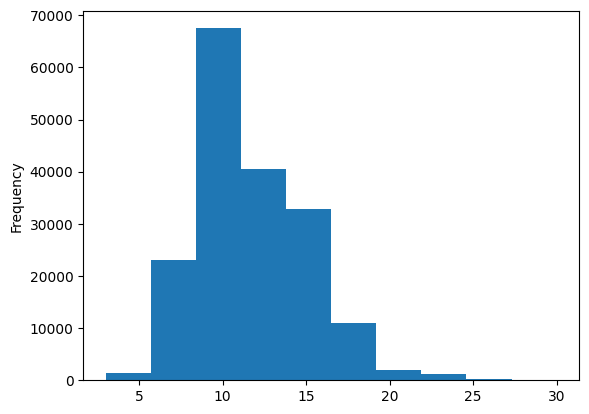

In [16]:
#Lets length of different lines
train_df.total_lines.plot.hist();

### Get list of sentences

In [17]:
#Convert abstract text lines into list
train_sentences=train_df.text.to_list()
val_sentences=val_df.text.to_list()
test_sentences=test_df.text.to_list()
len(train_sentences),len(val_sentences),len(test_sentences),

(180040, 30212, 30135)

In [18]:
#View 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make Numeric labels (ML Models also require numeric labels)

In [19]:
# One Hot Encoding labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder=OneHotEncoder(sparse_output=False)
train_labels_one_hot=one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot=one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot=one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

#What one hot encoded target labels looks like?
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label Encoded Labels

In [20]:
#Extract labels ('target columns') and encode into integers
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_label_encoded=label_encoder.fit_transform(train_df['target'])
val_label_encoded=label_encoder.transform(val_df['target'])
test_label_encoded=label_encoder.transform(test_df['target'])

#train label encoded looks like?
train_label_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [21]:
#Get class names and number of classes from labelEncoder instance
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_
num_classes,class_names


(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments...

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline (TF-IDF Multinomial Navie Bayes Classifier)

## Model 0: Getting a Baseline Model

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#Create a pipeline
model_0=Pipeline([
    ('TF-IDF',TfidfVectorizer()),
    ('Classifier',MultinomialNB())
])

#Fit the pipeline to the training data
model_0.fit(X=train_sentences,y=train_label_encoded)

Pipeline(steps=[('TF-IDF', TfidfVectorizer()), ('Classifier', MultinomialNB())])

In [23]:
#Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,y=val_label_encoded)

0.7218323844829869

In [24]:
#Make prediction using our baseline model
baseline_preds=model_0.predict(val_sentences)
baseline_preds[:20]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4, 0, 4, 1, 1, 2, 2, 4, 1, 4, 4])

### Download Helper functions scripts

In the previous module , we wrote a function to compare predictions across different metrics (accu,preci,f1,recall) and rather than rewriting it here, lets download it from a our helper function script.

https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

In [25]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2024-12-30 09:45:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-12-30 09:45:43 (84.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [26]:
from helper_functions import calculate_results

In [27]:
baseline_results=calculate_results(y_true=val_label_encoded,
                                   y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [28]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Preparing our data(the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [30]:
# how long is each sentence on average?
sent_lens=[len(sentence.split()) for sentence in train_sentences]
sent_lens[:5]

[49, 27, 15, 14, 35]

In [31]:
avg_sent_len=np.mean(sent_lens)
max_sent_len=np.max(sent_lens)
min_sent_len=np.min(sent_lens)

avg_sent_len,max_sent_len,min_sent_len

(26.338269273494777, 296, 1)

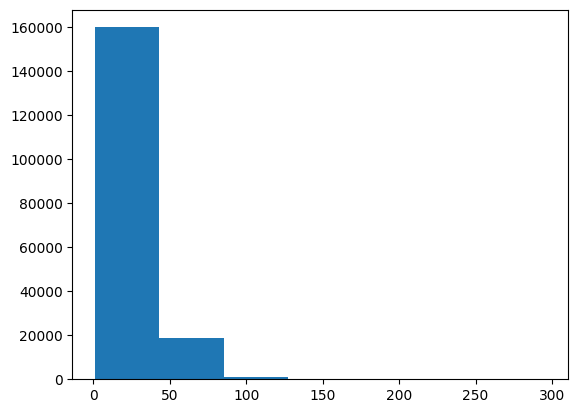

In [32]:
#What distribution looks like?
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=7);

In [33]:
# How long a sentence lengths overs 95% of examples?
output_seq_len=int(np.percentile(sent_lens,95))
output_seq_len

55

In [34]:
# Maximum sequence length in training sen
max(sent_lens)

296

### Create Text vectorizer
 We want to make a layer which maps our transform words into numbers

In [35]:
# How many words are in our vocabulary?(taken table-2 from research paper)
max_tokens=68000


In [36]:
#Create text vectorizer
from tensorflow.keras.layers  import TextVectorization

text_vectorizer=TextVectorization(max_tokens=max_tokens,# number of words in vocabulary
                                  output_sequence_length=output_seq_len) #desired output length of vectorized  sequence

In [37]:
#Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [38]:
# Test out text vectorizer on random sentences
import random
target_sentence=random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of Text:{len(target_sentence.split())}")
print(f"\nVectorized Text:\n{text_vectorizer([target_sentence])}")

Text:
the overall response rate was @ % with abvd and @ % with stanford v.

Length of Text:15

Vectorized Text:
[[    2   188   142    78    10     7  8148     3     7 10958  1010     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [39]:
# How many words in our training vocabulary?
rct_20k_text_vocab=text_vectorizer.get_vocabulary()
print(f"Number of words in vocab:{len(rct_20k_text_vocab)}")
print(f"Most Common words in the vocab:{rct_20k_text_vocab[:5]}")
print(f"Least Common words in the vocab:{rct_20k_text_vocab[-5:]}")

Number of words in vocab:64841
Most Common words in the vocab:['', '[UNK]', 'the', 'and', 'of']
Least Common words in the vocab:['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [40]:
# Get a Config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create Custom text embeddings

In [41]:
token_embed=layers.Embedding(input_dim=len(rct_20k_text_vocab), #length of vocabulary
                             output_dim=128, #note: different embedding sizes result in drastically different number of parameters
                             mask_zero=True, # use masking to handle variable sequence length (save space)
                             name='Token_embedding')

In [42]:
#Show example embedding
print(f"Sentence before Vectorization:\n{target_sentence}\n")
vectorized_sentence=text_vectorizer([target_sentence])
print(f"Sentence after Vectorization:\n{vectorized_sentence}\n")
embedded_sentence=token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}")
print(f"Embedded Sentence Shape:{embedded_sentence.shape}")

Sentence before Vectorization:
the overall response rate was @ % with abvd and @ % with stanford v.

Sentence after Vectorization:
[[    2   188   142    78    10     7  8148     3     7 10958  1010     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.01632717 -0.02178093  0.0144352  ... -0.00335373 -0.00170587
   -0.02683376]
  [-0.01511297  0.02285793 -0.00561031 ...  0.04892598  0.01371995
    0.02150729]
  [-0.03435906  0.04365499  0.02767665 ... -0.01567174 -0.01637483
   -0.02893062]
  ...
  [ 0.03131365 -0.02970461  0.01454565 ... -0.01384945 -0.02428377
    0.04283499]
  [ 0.03131365 -0.02970461  0.01454565 ... -0.01384945 -0.02428377
    0.04283499]
  [ 0.03131365 -0.02970461  0.01454565 ... -0.01384945 -0.02428377
    0.042834

## Creating datasets (making sure our data loads fast as possible)

We're going to setup our data to run as fast possible with the Tensorflow  tf.data API, many of the steps here are discussed at length in the these two resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [43]:
# Turn our data into Tensorflow Datasets
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [44]:
train_labels_one_hot.shape

(180040, 5)

In [45]:
#Takes the TensorSliceDatasets and turn them into prefetched datasets
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset=valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [46]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with Token Embeddings

In [47]:
#Create 1D Conv Model to process sequences
inputs=layers.Input(shape=(1,),dtype=tf.string)
text_vectors=text_vectorizer(inputs) # Vectorize text inputs
token_embedding=token_embed(text_vectors) # Create embedding
x=layers.Conv1D(filters=63,kernel_size=5,activation='relu',padding='same')(token_embedding)
x=layers.GlobalAveragePooling1D()(x) #condense the output of our feature vector from Conv layer
outputs=layers.Dense(num_classes,activation='softmax')(x)
model_1=tf.keras.Model(inputs,outputs)


#Compile the model
model_1.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [48]:
# Model Summary
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 55)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Token_embedding (Embedding)          │ (None, 55, 128)             │       8,299,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 55, 63)              │          40,383 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 63)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             320 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,340,351 (31.82 MB)

 Trainable params: 8,340,351 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
#Fit the model
history_model_1=model_1.fit(train_dataset,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            epochs=5,
                            validation_data=valid_dataset,
                            validation_steps=int(0.1*len(valid_dataset)) # only validate on 10% of batches
                            )

Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 63s 109ms/step - accuracy: 0.5065 - loss: 1.1823 - val_accuracy: 0.7364 - val_loss: 0.6945
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 80s 143ms/step - accuracy: 0.7453 - loss: 0.6875 - val_accuracy: 0.7646 - val_loss: 0.6308
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 60s 107ms/step - accuracy: 0.7686 - loss: 0.6250 - val_accuracy: 0.7859 - val_loss: 0.5950
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 73s 129ms/step - accuracy: 0.7859 - loss: 0.5989 - val_accuracy: 0.8039 - val_loss: 0.5678
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 61s 109ms/step - accuracy: 0.7888 - loss: 0.5875 - val_accuracy: 0.7962 - val_loss: 0.5650


In [50]:
#Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8030 - loss: 0.5556


[0.5584591627120972, 0.8027274012565613]

In [51]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs=model_1.predict(valid_dataset)
model_1_pred_probs,model_1_pred_probs.shape

945/945 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step


(array([[5.6046087e-01, 1.4160250e-01, 5.1393650e-02, 1.8480951e-01,
         6.1733492e-02],
        [5.3213656e-01, 2.7773017e-01, 1.6947284e-02, 1.4766943e-01,
         2.5516441e-02],
        [1.7532492e-01, 4.0037148e-03, 9.9426426e-04, 8.1964803e-01,
         2.9113506e-05],
        ...,
        [1.8651834e-05, 4.8965379e-04, 2.9883191e-03, 1.0171239e-05,
         9.9649316e-01],
        [1.0894731e-01, 2.4320018e-01, 1.5344915e-01, 5.6520697e-02,
         4.3788269e-01],
        [1.3756149e-01, 7.6495820e-01, 5.0971005e-02, 1.7468702e-02,
         2.9040614e-02]], dtype=float32),
 (30212, 5))

In [52]:
#Convert pred probs to classes
model_1_preds=tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [53]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [54]:
print(type(val_label_encoded))
print(type(model_1_preds))

<class 'numpy.ndarray'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [55]:
#Calculate model_1 results
model_1_results=calculate_results(y_true=val_label_encoded,
                                  y_pred=model_1_preds.numpy())
model_1_results

{'accuracy': 80.27273930888389,
 'precision': 0.8024480152654853,
 'recall': 0.8027273930888389,
 'f1': 0.7997815673140277}

In [56]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature Extraction  with Pretrained token embeddings

Now Lets use pretrained word embeddings from tensorflow hub,
Universal Sentence encoder:
[USE](https://tfhub.dev/google/universal-sentence-encoder/4)

The Paper originally used GloVe Embeddings, however we're going to stick with the later created USE Pretrained embeddings.

In [57]:
# Download pretrained tensorflow hub USE
import tensorflow_hub as hub

tf_hub_embedding_layer=hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                      trainable=False,
                                      input_shape=[],
                                      dtype=tf.string,
                                      name='universal_sentence_encoder')

In [58]:
# Test out the pretrained embeddings on a random sentences
random_train_sentences=random.choice(train_sentences)
print(f"Train Sentences:\n{random_train_sentences}")
use_embedded_sentence=tf_hub_embedding_layer([random_train_sentences])
print(f"Sentence after embedding:\n{use_embedded_sentence}")
print(f"Length of sentences embedding:{len(use_embedded_sentence[0])}")

Train Sentences:
randomized , controlled , clinical trial .
Sentence after embedding:
[[-5.75573416e-03  3.21560283e-03 -3.12764049e-02 -1.27467257e-03
   2.30795611e-02 -6.50591869e-03  2.48195622e-02 -6.75203558e-03
   4.37860005e-02  1.20430468e-02  8.24166834e-02 -2.05632243e-02
   6.95061088e-02 -2.85219755e-02  4.82817516e-02 -3.63939814e-02
  -8.27384517e-02  4.58805002e-02  1.30877336e-02 -5.13572544e-02
  -4.44993265e-02  2.51626000e-02 -6.17081821e-02  8.27966258e-03
   6.20541396e-03 -6.54965043e-02 -2.45954189e-02  7.94945583e-02
  -5.06459922e-02  2.42941156e-02  6.27072006e-02  8.37685987e-02
   2.13032793e-02  6.47742078e-02  2.30166391e-02  2.50659045e-02
  -7.95524120e-02 -4.45857644e-02 -4.90952507e-02  2.32133456e-02
  -6.33953735e-02  3.33061963e-02 -2.88007855e-02 -3.79932486e-02
   1.28195873e-02 -3.28244194e-02 -1.62692834e-02  7.41760805e-02
  -3.21621224e-02  4.12730407e-03  4.54113856e-02  1.07366014e-02
  -3.18624415e-02  2.82157096e-03 -5.53710535e-02 -4.994

## Building and fitting an NLP feature extraction model using pretrained embeddings Tensorflow HUb

In [59]:
print(tf.__version__)
print(hub.__version__)

2.17.1
0.16.1


In [60]:
# Define the custom layer to warp the UNIVERSAL SENTENCE ENCODER
from tensorflow.keras.layers import Layer


class USELayer(Layer):
  def __init__(self,url='https://tfhub.dev/google/universal-sentence-encoder/4',**kargs):
    super(USELayer,self).__init__(**kargs)
    self.use_model=hub.load(url)

  def call(self,inputs):
    return self.use_model(inputs)


In [61]:
#Define feature extraction model using TF hub layers
inputs=layers.Input(shape=[],dtype=tf.string)
pretrained_embedding=USELayer()(inputs) # tokenize the text and create embedding of each sequence (512 long vectors)
x=layers.Dense(128,activation='relu')(pretrained_embedding)
#Note: u could add more layers here it you wanted to
outputs=layers.Dense(num_classes,activation='softmax')(x) #create the output layer

#Create a model
model_2=tf.keras.Model(inputs,
                       outputs,
                       name='model_2_USE_feature_extractor')

#Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

#Struture of model_2
model_2.summary()


Model: "model_2_USE_feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ use_layer (USELayer)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,309 (259.02 KB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

#Fit the model
history_model_2=model_2.fit(train_dataset,
            steps_per_epoch=int(0.1*len(train_dataset)),
            epochs=5,
            validation_data=valid_dataset,
            validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5793 - loss: 1.0906 - val_accuracy: 0.6908 - val_loss: 0.7949
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.7035 - loss: 0.7699 - val_accuracy: 0.7131 - val_loss: 0.7551
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7139 - loss: 0.7542 - val_accuracy: 0.7204 - val_loss: 0.7283
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.7247 - loss: 0.7190 - val_accuracy: 0.7317 - val_loss: 0.7161
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.7242 - loss: 0.7194 - val_accuracy: 0.7427 - val_loss: 0.7000


In [63]:
model_2.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7322 - loss: 0.6959


[0.6983879804611206, 0.7338143587112427]

In [64]:
# make predictions with feature extraction model
model_2_pred_probs=model_2.predict(valid_dataset)
model_2_pred_probs[:10]

945/945 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step


array([[6.2582994e-01, 2.2866318e-01, 2.9428219e-03, 1.3329341e-01,
        9.2705861e-03],
       [4.4590235e-01, 4.5363858e-01, 5.6761145e-03, 9.1995992e-02,
        2.7869744e-03],
       [3.4649876e-01, 6.8085045e-02, 4.7101080e-02, 4.8745960e-01,
        5.0855406e-02],
       [6.3843564e-03, 1.3366930e-02, 9.3935251e-01, 4.1638040e-03,
        3.6732320e-02],
       [1.0011102e-02, 9.8582111e-02, 5.1002359e-01, 5.3496268e-03,
        3.7603360e-01],
       [3.3801855e-04, 1.1890517e-03, 7.9867613e-01, 6.1001021e-05,
        1.9973578e-01],
       [1.0777477e-03, 3.0286976e-03, 6.0839838e-01, 7.4216904e-04,
        3.8675296e-01],
       [1.9010436e-03, 1.8410644e-02, 6.6836154e-01, 5.9622386e-04,
        3.1073049e-01],
       [3.5528725e-04, 3.8041696e-03, 1.6403275e-02, 5.4171268e-04,
        9.7889560e-01],
       [1.6446777e-01, 5.3306460e-01, 7.9054244e-02, 6.1792951e-02,
        1.6162047e-01]], dtype=float32)

In [65]:
# Convert the prediction probabilities with feature extraction model to labels
model_2_preds=np.argmax(model_2_pred_probs,axis=1)
model_2_preds[:10]

array([0, 1, 3, 2, 2, 2, 2, 2, 4, 1])

In [66]:
# Calculate results from tf hub pretrained embeddings  results on val set
model_2_results=calculate_results(y_true=val_label_encoded,
                                  y_pred=model_2_preds)
model_2_results

{'accuracy': 73.38143783926915,
 'precision': 0.7298245141773667,
 'recall': 0.7338143783926916,
 'f1': 0.7280584317171018}

In [67]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 3: Conv1D with Character Embeddings

The paper we've replicating states they used a combination of token and character-level embeddings.

Previously, we;ve made token level embeddings but we need similar for characters if we want to use char-level embeddings

### Creating a character-level tokenizer

In [68]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [69]:
#Make function to split sentences into characters
def split_text_into_chars(text):
  return " ".join(list(text))

#Text splitting non-character level sequence into characters
split_text_into_chars(random_train_sentences)

'r a n d o m i z e d   ,   c o n t r o l l e d   ,   c l i n i c a l   t r i a l   .'

In [70]:
#Split sequences-level data splits into character-level data splits
train_chars=[split_text_into_chars(sentence) for sentence in train_sentences]
val_chars=[split_text_into_chars(sentence) for sentence in val_sentences]
test_chars=[split_text_into_chars(sentence) for sentence in test_sentences]
train_chars[:3]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [71]:
# Whats the average character length?
chars_lens=[len(sentence) for sentence in train_sentences]
mean_char_len=np.mean(chars_lens)
mean_char_len

149.3662574983337

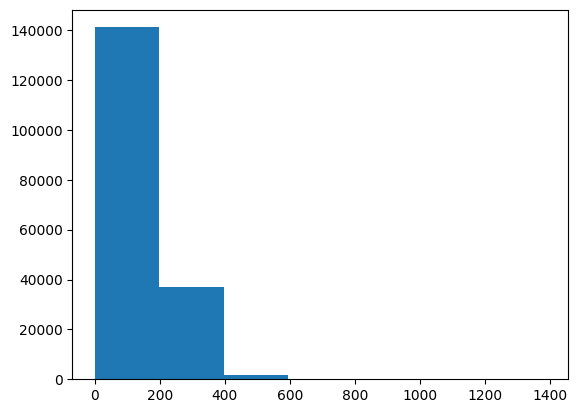

In [72]:
#Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt

plt.hist(chars_lens,bins=7);

In [73]:
# Find the character lengths covers 95% of sequences
output_seq_char_len=int(np.percentile(chars_lens,95))
output_seq_char_len

290

In [74]:
# Get all the keyboard characters
import string
alphabet=string.ascii_lowercase+string.digits+string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [75]:
#Create a character-level token vectorizer instance
NUM_CHARS_TOKENS=len(alphabet) +2 # add 2 for space and OOV token(oov-out of vocab,'[UNK]')
char_vectorizer=TextVectorization(max_tokens=NUM_CHARS_TOKENS,
                                  output_sequence_length=output_seq_char_len,
                                  standardize=None,
                                  name='char_vectorizer')

In [76]:
#Adapt the character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [77]:
#Check characters vocab stats
char_vocab=char_vectorizer.get_vocabulary()
print(f"Number of characters in vocab:{len(char_vocab)}")
print(f"5 Most Common Characters :{char_vocab[:5]}")
print(f"5 Least Common Characters :{char_vocab[-5:]}")

Number of characters in vocab:57
5 Most Common Characters :['', '[UNK]', 'e', 't', 'i']
5 Least Common Characters :['|', '"', ']', '\\', '[']


In [78]:
# Test out character vectorizer
random_train_chars=random.choice(train_chars)
print(f"Text:\n{random_train_chars}\n")
print(f"Length of random_train_chars:{len(random_train_chars.split())}")
vectorized_chars=char_vectorizer([random_train_chars])
print(f"Vectorized Text:\n{vectorized_chars}")
print(f"Length of Vectorized chars :{len(vectorized_chars[0])}")

Text:
t h e   n u m b e r   o f   p a t i e n t s   w h o   n e e d   t o   u n d e r g o   s u r g e r y   f o r   o n e   a d d i t i o n a l   p e r s o n   t o   h a v e   a   m e a n i n g f u l   i m p r o v e m e n t   i n   t h e   q o l i e - @   i s   t w o   (   n u m b e r   n e e d e d   t o   t r e a t   =   @   )   .

Length of random_train_chars:133
Vectorized Text:
[[ 3 13  2  6 16 15 23  2  8  7 17 14  5  3  4  2  6  3  9 21 13  7  6  2
   2 10  3  7 16  6 10  2  8 18  7  9 16  8 18  2  8 20 17  7  8  7  6  2
   5 10 10  4  3  4  7  6  5 12 14  2  8  9  7  6  3  7 13  5 22  2  5 15
   2  5  6  4  6 18 17 16 12  4 15 14  8  7 22  2 15  2  6  3  4  6  3 13
   2 34  7 12  4  2 26 19  4  9  3 21  7 28  6 16 15 23  2  8  6  2  2 10
   2 10  3  7  3  8  2  5  3 33 19 27 25  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0 

### Creating a character-level embedding

In [79]:
# Create char embedding layer
char_embed=layers.Embedding(input_dim=len(char_vocab),# number of different characters
                            output_dim=25, # this is the size of the char embedding in the paper:pub_med_rct_200k
                            mask_zero=True,
                            name='char_embed')

In [80]:
# Test our character embedding layer
print(f"Charified text:\n{random_train_chars}\n")
char_embed_example=char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded Chars. (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape:{char_embed_example.shape}")

Charified text:
t h e   n u m b e r   o f   p a t i e n t s   w h o   n e e d   t o   u n d e r g o   s u r g e r y   f o r   o n e   a d d i t i o n a l   p e r s o n   t o   h a v e   a   m e a n i n g f u l   i m p r o v e m e n t   i n   t h e   q o l i e - @   i s   t w o   (   n u m b e r   n e e d e d   t o   t r e a t   =   @   )   .

Embedded Chars. (after vectorization and embedding):
[[[-0.02785432 -0.0018265   0.02524129 ... -0.0211166  -0.0138535
    0.04306516]
  [-0.03907322 -0.0388638   0.03441527 ...  0.04526552 -0.00669827
   -0.03128723]
  [ 0.04627048  0.01343976  0.04989615 ...  0.01740395 -0.01367231
    0.02078838]
  ...
  [-0.03873765  0.04729256  0.04275243 ... -0.00990225 -0.03515249
    0.01703943]
  [-0.03873765  0.04729256  0.04275243 ... -0.00990225 -0.03515249
    0.01703943]
  [-0.03873765  0.04729256  0.04275243 ... -0.00990225 -0.03515249
    0.01703943]]]

Character embedding shape:(1, 290, 25)


In [81]:
len(random_train_chars)

327

### Building a Conv1D model to fit on character embeddings

In [82]:
# Make Conv1D on chars only
inputs=layers.Input(shape=(1,),dtype=tf.string)
char_vectors=char_vectorizer(inputs)
char_embeddings=char_embed(char_vectors)
x=layers.Conv1D(filters=128,kernel_size=5,activation='relu',padding='same')(char_embeddings)
x=layers.GlobalMaxPooling1D()(x)
outputs=layers.Dense(num_classes,activation='softmax')(x)

model_3=tf.keras.Model(inputs,outputs)

#Compile the model
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

#Summary of Model
model_3.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_vectorizer (TextVectorization)  │ (None, 290)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_embed (Embedding)               │ (None, 290, 25)             │           1,425 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 290, 128)            │          16,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,198 (71.09 KB)

 Trainable params: 18,198 (71.09 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
#Create char level datasets
train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset=tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [84]:
#Fit the model on chars only
model_3_history=model_3.fit(train_char_dataset,
                            steps_per_epoch=int(0.1*len(train_char_dataset)),
                            epochs=5,
                            validation_data=valid_char_dataset,
                            validation_steps=int(0.1*len(valid_char_dataset)))

Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.4677 - loss: 1.2840 - val_accuracy: 0.6589 - val_loss: 0.8943
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - accuracy: 0.6531 - loss: 0.8800 - val_accuracy: 0.6912 - val_loss: 0.7892
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.6913 - loss: 0.7983 - val_accuracy: 0.7108 - val_loss: 0.7396
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.7209 - loss: 0.7465 - val_accuracy: 0.7360 - val_loss: 0.6963
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.7256 - loss: 0.7090 - val_accuracy: 0.7487 - val_loss: 0.6867


In [85]:
#Make predictions with character embeddings
model_3_pred_probs=model_3.predict(valid_char_dataset)
model_3_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step


array([[0.06591421, 0.7608855 , 0.02919803, 0.13083667, 0.01316566],
       [0.19357914, 0.6416988 , 0.00385638, 0.14296092, 0.01790477],
       [0.1467374 , 0.2768062 , 0.07268471, 0.48342988, 0.02034175],
       ...,
       [0.00506905, 0.00368292, 0.03945906, 0.00911882, 0.94267017],
       [0.0179472 , 0.19782208, 0.2310886 , 0.04228218, 0.51085997],
       [0.23510855, 0.7151737 , 0.02498725, 0.02153652, 0.00319404]],
      dtype=float32)

In [86]:
#Convert the prediction probabilities to class labels
model_3_pred=np.argmax(model_3_pred_probs,axis=1)
model_3_pred

array([1, 1, 3, ..., 4, 4, 1])

### Experiments
1. standardize remove(punctuation and trucate)  - 63%
2. standardize include above punctuation aand truncation - 71%
3. Conv1D kernel=3 with 1 same - 63%
4. Conv1D filters=128 - 70%


I am considering standardize to none as final conclusion for model_3 performance.

In [87]:
# Calculate the results for Conv1D chars only
model_3_results=calculate_results(y_true=val_label_encoded,
                                  y_pred=model_3_pred)
model_3_results

{'accuracy': 74.03018668078909,
 'precision': 0.747392737903355,
 'recall': 0.7403018668078909,
 'f1': 0.7383667397249188}

In [88]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 4: Combining pretrained token embeddings + character embeddings (bybrid embedding layer)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.concatenate`) layer
4. Build a series of output layer on top of 3 similar to Figure 1 and section 4.2 of research paper of pub_med_rct_200k
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output|

In [89]:
# 1.setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = USELayer()(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [90]:
# Get A summary of our model
model_4.summary()

Model: "model_4_token_and_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_input (InputLayer)  │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_input[0][0]       │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ use_layer_1 (USELayer)    │ (None, 512)            │              0 │ token_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embed (Embedding)    │ (None, 290, 25)        │          1,425 │ char_vectorizer[1][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, 290)            │              0 │ char_vectorizer[1][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │         65,664 │ use_layer_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 50)             │         10,200 │ char_embed[1][0],      │
│ (Bidirectional)           │                        │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid         │ (None, 178)            │              0 │ dense_4[0][0],         │
│ (Concatenate)             │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 178)            │              0 │ token_char_hybrid[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 128)            │         22,912 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 5)              │            645 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 100,846 (393.93 KB)

 Trainable params: 100,846 (393.93 KB)

 Non-trainable params: 0 (0.00 B)

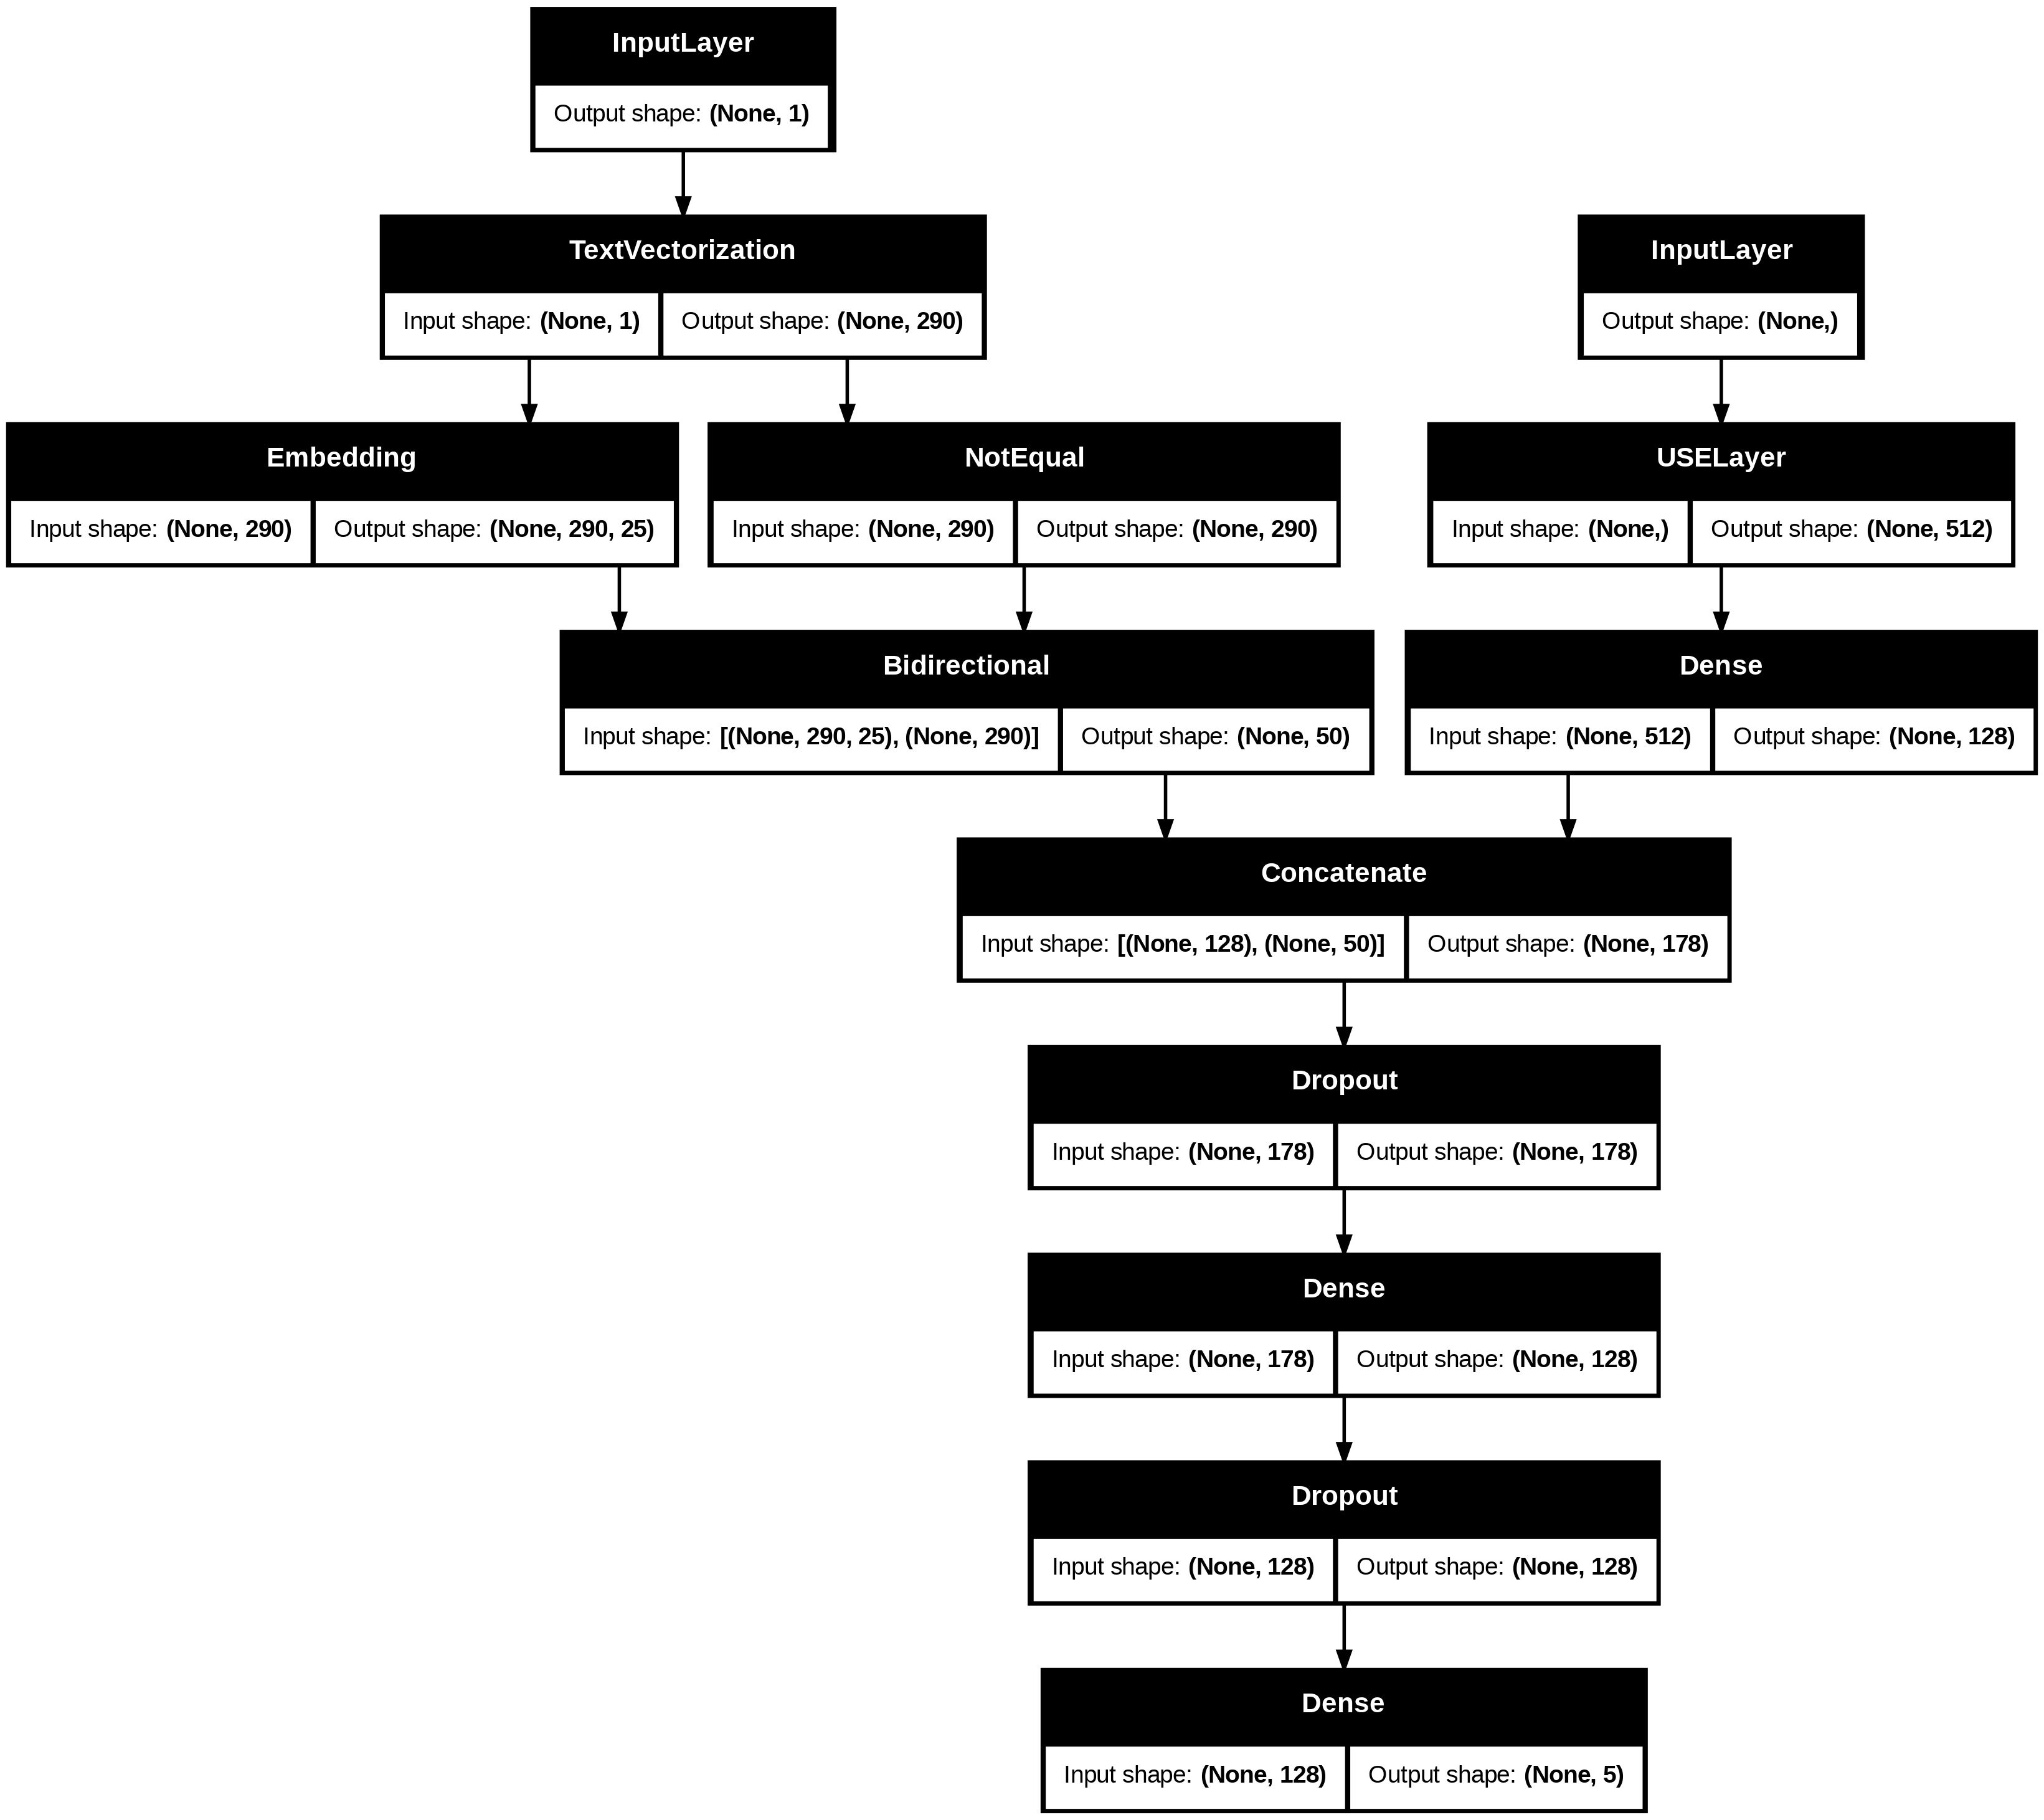

In [91]:
#Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4,show_shapes=True)

In [92]:
#Compile the token char
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(), #section 4.3 of the paper says that use SGD , you might want to try this
                metrics=['accuracy'])

### Combining token and character data into tf.data Dataset

In [93]:
# Combine chars and token into a dataset
train_char_token_data=tf.data.Dataset.from_tensor_slices((train_sentences,train_chars)) #make data
train_char_token_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset=tf.data.Dataset.zip((train_char_token_data,train_char_token_labels)) #Combine data with labels

#Prefetch and Batch train dataset
train_char_token_dataset=train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [94]:
# Combine chars and token into a dataset
val_char_token_data=tf.data.Dataset.from_tensor_slices((val_sentences,val_chars)) #make data
val_char_token_labels=tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset=tf.data.Dataset.zip((val_char_token_data,val_char_token_labels)) #Combine data with labels

#Prefetch and Batch train dataset
val_char_token_dataset=val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [95]:
# Check out our training char and token embedding dataset
train_char_token_dataset,val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [96]:
# Fit the model on tokens and chars
history_model_4=model_4.fit(train_char_token_dataset,
                            steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                            epochs=5,
                            validation_data=val_char_token_dataset,
                            validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 277s 476ms/step - accuracy: 0.5243 - loss: 1.1566 - val_accuracy: 0.7005 - val_loss: 0.7750
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 331s 590ms/step - accuracy: 0.6957 - loss: 0.7948 - val_accuracy: 0.7211 - val_loss: 0.7236
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 287s 511ms/step - accuracy: 0.7094 - loss: 0.7655 - val_accuracy: 0.7453 - val_loss: 0.6640
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 211s 375ms/step - accuracy: 0.7295 - loss: 0.7196 - val_accuracy: 0.7550 - val_loss: 0.6515
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 232s 413ms/step - accuracy: 0.7323 - loss: 0.7181 - val_accuracy: 0.7533 - val_loss: 0.6443


In [97]:
#Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 73s 77ms/step - accuracy: 0.7558 - loss: 0.6407


[0.6411321759223938, 0.756719172000885]

In [98]:
#Make predictions using the token-character model hybrid
model_4_pred_probs=model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 75s 78ms/step


array([[5.3782088e-01, 2.6736978e-01, 5.2379691e-03, 1.8069248e-01,
        8.8788532e-03],
       [3.8970968e-01, 4.9246168e-01, 6.9524730e-03, 1.0732846e-01,
        3.5475520e-03],
       [3.4284592e-01, 5.4046907e-02, 4.1776024e-02, 5.4389513e-01,
        1.7436016e-02],
       ...,
       [1.1994674e-04, 1.0601437e-03, 2.5641343e-02, 3.8146940e-05,
        9.7314048e-01],
       [6.6907494e-03, 3.9223593e-02, 6.0429114e-01, 3.4375791e-03,
        3.4635687e-01],
       [2.6991379e-01, 5.0916648e-01, 1.7043595e-01, 9.0972297e-03,
        4.1386563e-02]], dtype=float32)

In [99]:
#Format pred probs into pred labels
model_4_pred=np.argmax(model_4_pred_probs,axis=1)
model_4_pred

array([0, 1, 3, ..., 4, 2, 1])

In [100]:
val_label_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [101]:
model_4_pred

array([0, 1, 3, ..., 4, 2, 1])

In [102]:
#Get results of token-char-hybrid model
model_4_results=calculate_results(y_true=val_label_encoded,
                                  y_pred=model_4_pred)
model_4_results

{'accuracy': 75.67191844300278,
 'precision': 0.7546343402196283,
 'recall': 0.7567191844300278,
 'f1': 0.7517565977455929}

In [103]:
model_1_results

{'accuracy': 80.27273930888389,
 'precision': 0.8024480152654853,
 'recall': 0.8027273930888389,
 'f1': 0.7997815673140277}

## Model 5 :Transfer Learning with pretrained token embeddings + Character embeddings + positional embeddings

In [104]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> 🔑**Notes:** Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

### Create positional embeddings

In [105]:
# How many different line numbers are there?
train_df['line_number'].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

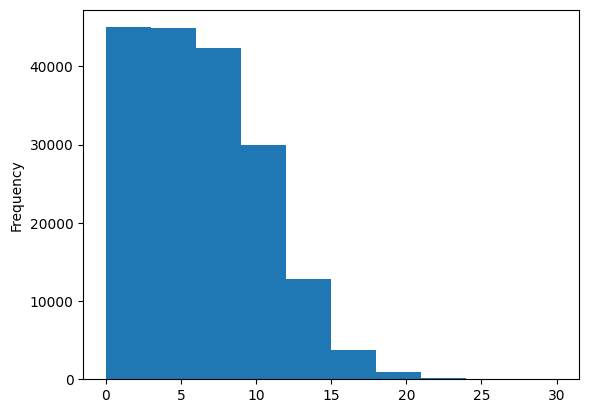

In [106]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [107]:
#Use tensorflow to create a one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot=tf.one_hot(train_df['line_number'].to_numpy(),depth=15)
val_line_numbers_one_hot=tf.one_hot(val_df['line_number'].to_numpy(),depth=15)
test_line_numbers_one_hot=tf.one_hot(test_df['line_number'].to_numpy(),depth=15)
train_line_numbers_one_hot[:10],train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

Now we;ve encoded our line numbers features, lets do the same for our total line features...

In [107]:
#How many different numbers of lines are theere?
train_df['total_lines'].value_counts()

<Axes: ylabel='Frequency'>

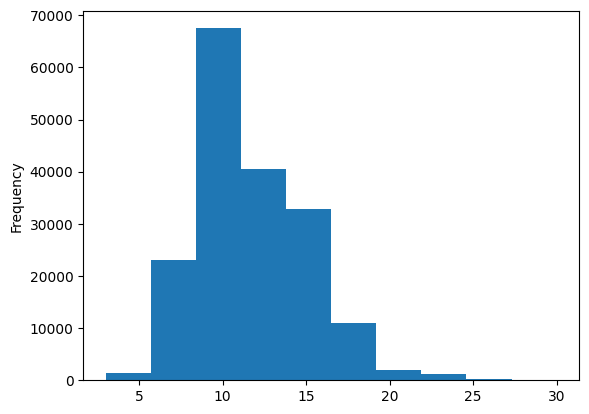

In [108]:
#Visualise the total lines
train_df['total_lines'].plot.hist()

In [109]:
# Check the coverage of a 'total_line' value of 20
np.percentile(train_df['total_lines'],98)

20.0

In [121]:
#USe Tensorflow to create one_hot_encoded tensors of our 'total_lines' features
train_total_lines_one_hot=tf.one_hot(train_df['total_lines'].to_numpy(),depth=20)
test_total_lines_one_hot=tf.one_hot(test_df['total_lines'].to_numpy(),depth=20)
val_total_lines_one_hot=tf.one_hot(val_df['total_lines'].to_numpy(),depth=20)
train_total_lines_one_hot.shape,train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a tribrid embedding model

1. Creating a token-level model
2. Create a character-level model
3. Create a model for the `line_number` feature
4. Create a model for the `total_lines` feature
5. Combine the outputs of 1 & 2 using `tf.keras.layers.Concatenate`
6. Combine the outputs of 3 ,4 & 5 using `tf.keras.layers.Concatenate`
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of the 1,2,3,4 and outputs of the into a `tf.keras.Model`

In [114]:
# 1. Token inputs
token_inputs=layers.Input(shape=[],dtype=tf.string,name='token_inputs')
token_embeddings=USELayer()(token_inputs)
token_outputs=layers.Dense(128,activation='relu')(token_embeddings)
token_model=tf.keras.Model(inputs=token_inputs,
                           outputs=token_outputs)

# 2. Char inputs
char_inputs=layers.Input(shape=(1,),dtype=tf.string,name='char_inputs')
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model=tf.keras.Model(inputs=char_inputs,
                          outputs=char_bi_lstm)

# 3. Line numbers model
# inputs,shape=?
line_number_inputs=layers.Input(shape=[15,],dtype=tf.float32,name='line_number_inputs')
#Dense layer with 32 units and relu activation
line_number_dense=layers.Dense(32,activation='relu')(line_number_inputs)
#Combine inputs and dense layer into model
line_number_model=tf.keras.Model(inputs=line_number_inputs,
                                 outputs=line_number_dense)

# 4. total line numbers
total_lines_inputs=layers.Input(shape=[20,],dtype=tf.float32,)
total_line_dense=layers.Dense(32,activation='relu')(total_lines_inputs)
total_lines_model=tf.keras.Model(inputs=total_lines_inputs,
                                 outputs=total_line_dense)

# 5. Combine the token and char embeddings into a hybrid embeddings
combined_embeddings=layers.Concatenate(name='char_token_hybrid_embeddings')([token_model.output,
                                                                char_model.output])
z=layers.Dense(256,activation='relu')(combined_embeddings)
z=layers.Dropout(0.5)(z)

# 6. Combine the positional embeddings with combined token and char embeddings
tribrid_embeddings=layers.Concatenate(name='char_token_postional_embeddings')([line_number_model.output,
                                                                               total_lines_model.output,
                                                                               z])

# 7. Create output layer
output_layer=layers.Dense(num_classes,activation='softmax')(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5=tf.keras.Model(inputs=[line_number_model.input,
                               total_lines_model.input,
                               token_model.input,
                               char_model.input],
                       outputs=output_layer,name='model_5_trbrid_embedding_model')

In [115]:
#Get a summary of tribrid embedding model
model_5.summary()

Model: "model_5_trbrid_embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_inputs (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_inputs (InputLayer) │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_inputs[0][0]      │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ use_layer_3 (USELayer)    │ (None, 512)            │              0 │ token_inputs[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embed (Embedding)    │ (None, 290, 25)        │          1,425 │ char_vectorizer[3][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_4 (NotEqual)    │ (None, 290)            │              0 │ char_vectorizer[3][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 128)            │         65,664 │ use_layer_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 48)             │          9,600 │ char_embed[3][0],      │
│ (Bidirectional)           │                        │                │ not_equal_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_token_hybrid_embedd… │ (None, 176)            │              0 │ dense_12[0][0],        │
│ (Concatenate)             │                        │                │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ line_number_inputs        │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 20)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 256)            │         45,312 │ char_token_hybrid_emb… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 32)             │            512 │ line_number_inputs[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 32)             │            672 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 256)            │              0 │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_token_postional_emb… │ (None, 320)            │              0 │ dense_13[0][0],        │
│ (Concatenate)             │                        │                │ dense_14[0][0],        │
│                           │                        │                │ dropout_3[0][0]        │
├──────────────────────

 Total params: 124,790 (487.46 KB)

 Trainable params: 124,790 (487.46 KB)

 Non-trainable params: 0 (0.00 B)

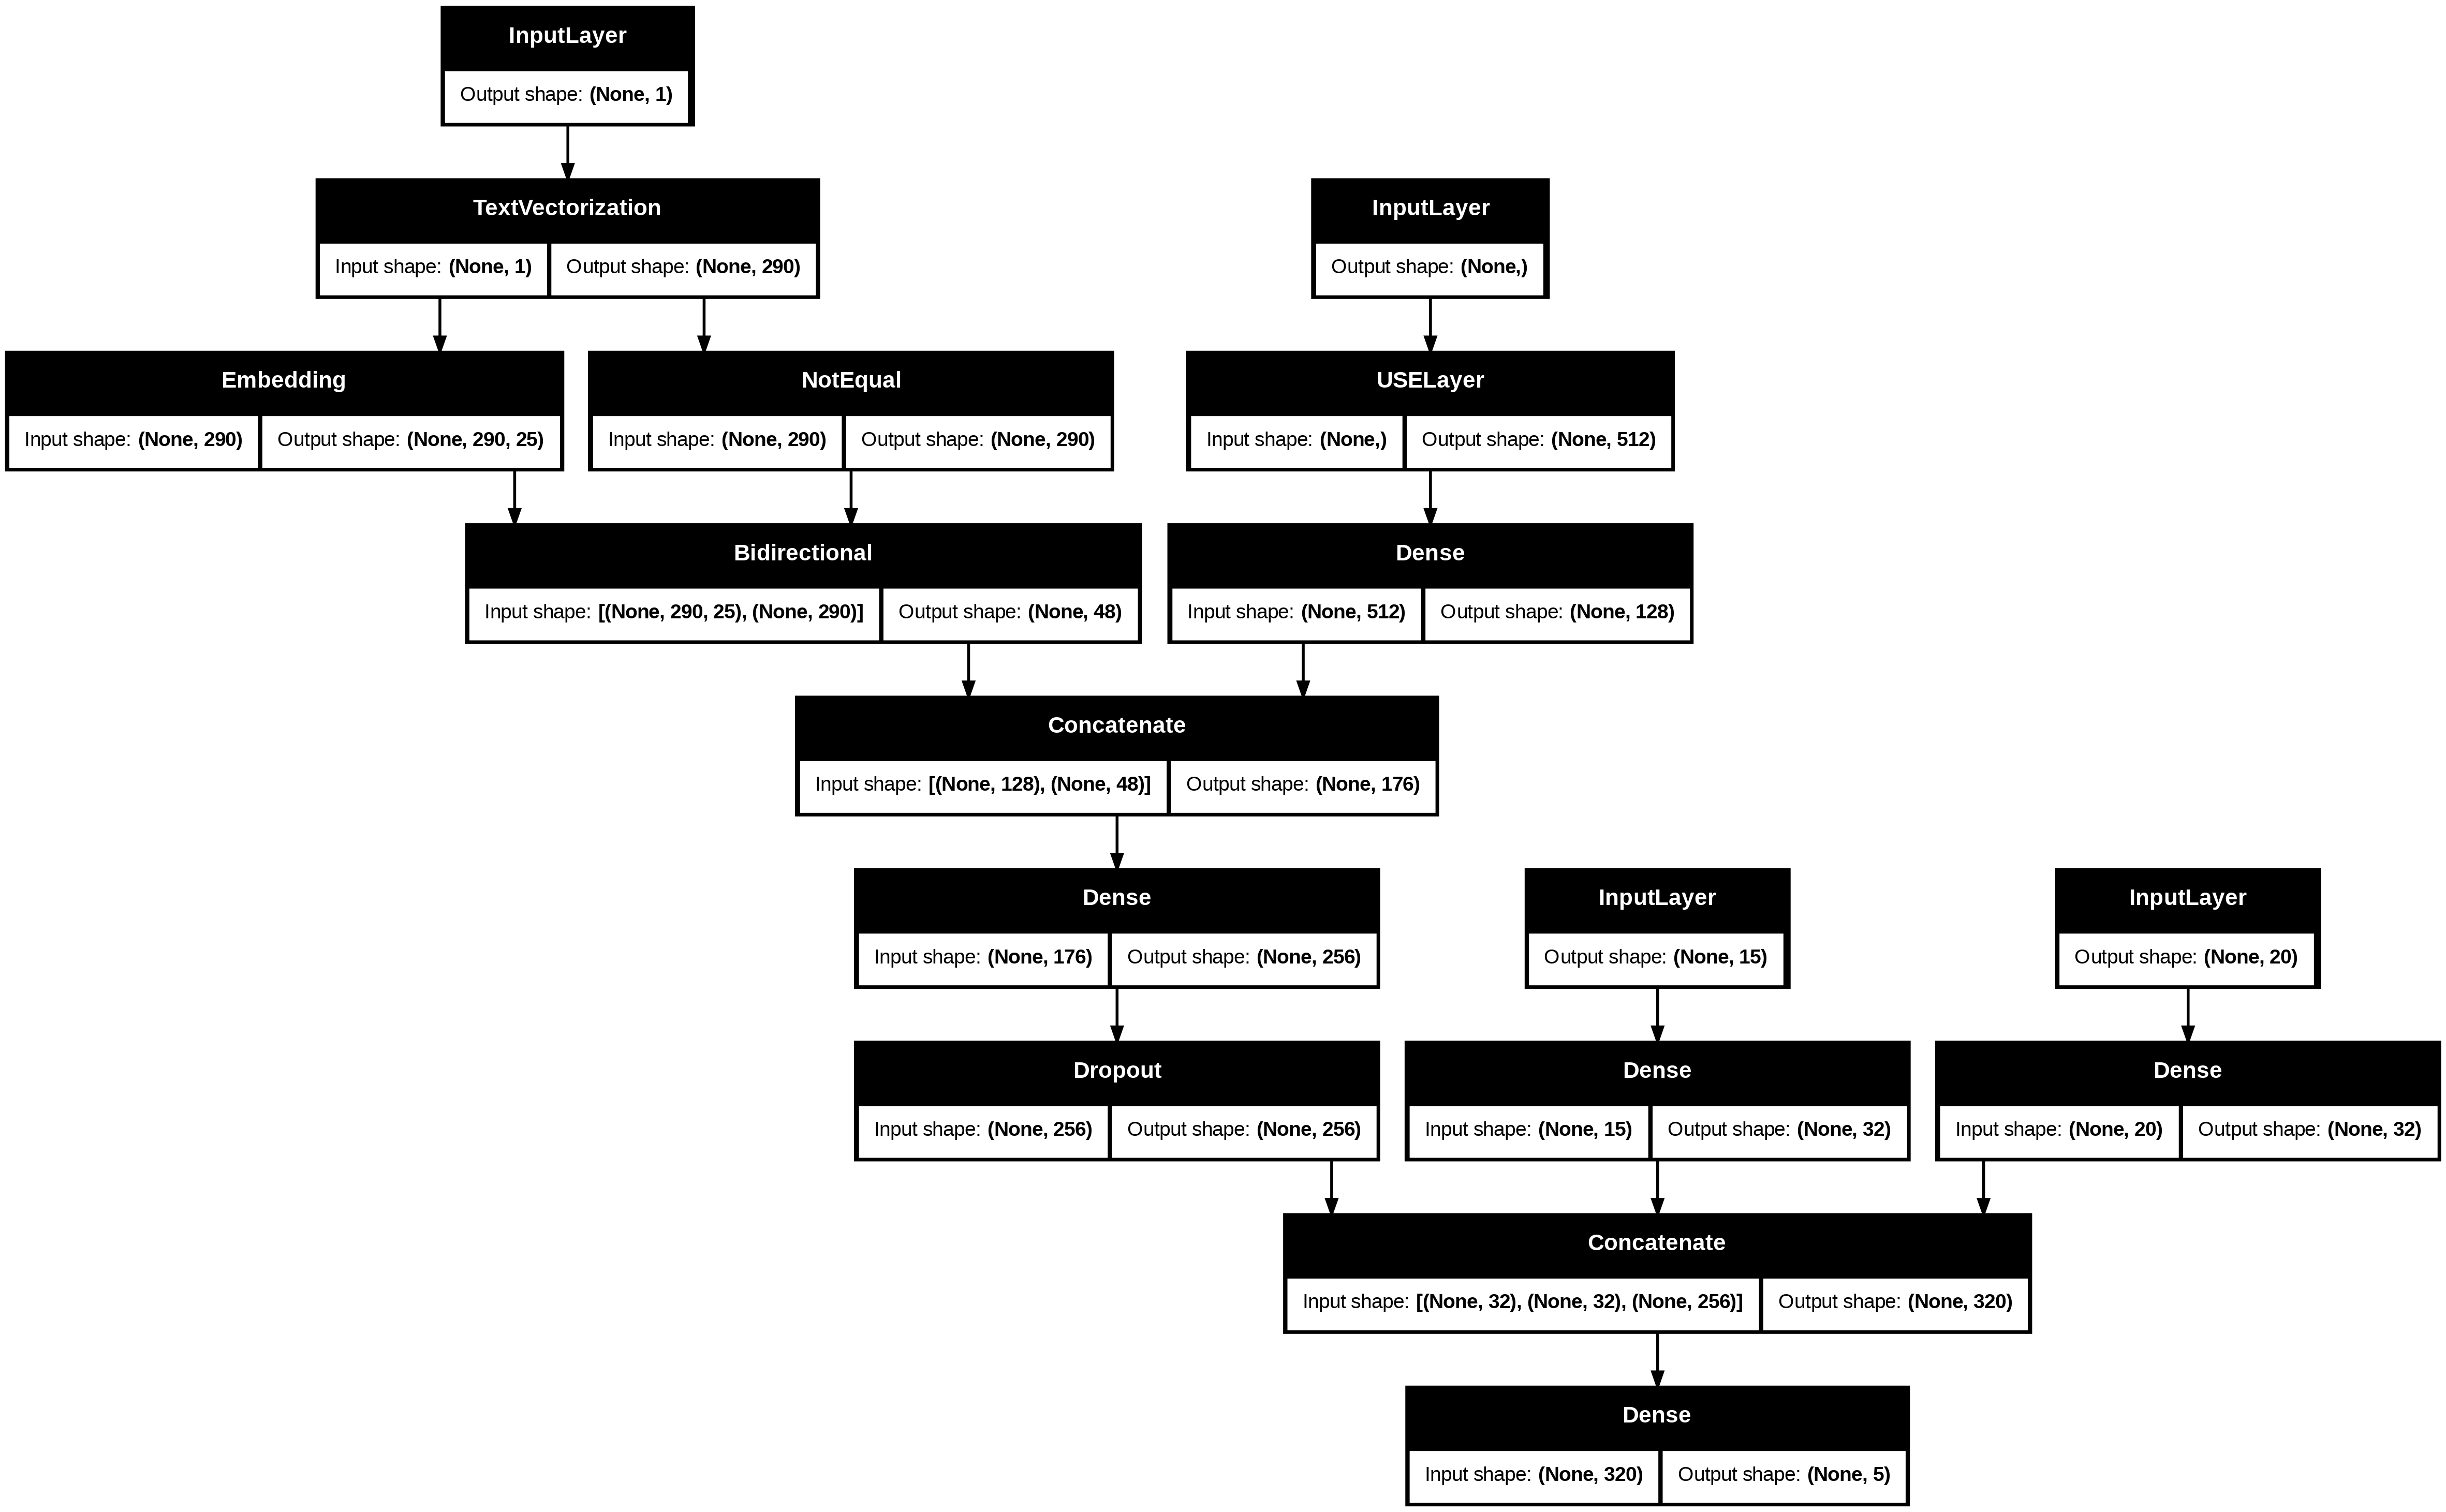

In [116]:
#Plot the model_5 to visually...
from keras.utils import plot_model
plot_model(model_5,show_shapes=True)

What is Label_Smoothing?

Ans. For example if our model gets too confident on single class.
(e.g. its prediction probability is really high) , it may be stuck on that class and not consider other classes...

Really Confident : `[0.0,0.0,1.0,0.0,0.1]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn hopefully proving generalization: `[0.01,0.01,0.96,0.01,0.01]`

In [117]:
# Compile token, char, and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), #Helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Create tribrid embedding datasets using tf.data

In [122]:
#Create training and validation dataset(with all 4 kinds of input data)
train_char_token_pos_dataset=tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset=tf.data.Dataset.zip((train_char_token_pos_dataset,
                                                  train_char_token_pos_labels))
train_char_token_pos_dataset=train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#Do the same for the validation dataset
val_char_token_pos_dataset=tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels=tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset=tf.data.Dataset.zip((val_char_token_pos_dataset,
                                                  val_char_token_pos_labels))
val_char_token_pos_dataset=val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [123]:
#Check input shapes
train_char_token_pos_dataset,val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predictions with our tribrid model

In [124]:
model_5.fit(train_char_token_pos_dataset,
            steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
            epochs=5,
            validation_data=val_char_token_pos_dataset,
            validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 207s 346ms/step - accuracy: 0.6365 - loss: 1.2205 - val_accuracy: 0.8082 - val_loss: 0.9811
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 193s 343ms/step - accuracy: 0.8187 - loss: 0.9649 - val_accuracy: 0.8305 - val_loss: 0.9371
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 191s 340ms/step - accuracy: 0.8269 - loss: 0.9479 - val_accuracy: 0.8434 - val_loss: 0.9294
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 191s 340ms/step - accuracy: 0.8394 - loss: 0.9330 - val_accuracy: 0.8451 - val_loss: 0.9157
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 197s 351ms/step - accuracy: 0.8432 - loss: 0.9247 - val_accuracy: 0.8438 - val_loss: 0.9077


In [125]:
model_5.evaluate(val_char_token_pos_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 119s 126ms/step - accuracy: 0.8452 - loss: 0.9134


[0.9144981503486633, 0.846087634563446]

In [126]:
#Make prediction with char token pos model
model_5_pred_probs=model_5.predict(val_char_token_pos_dataset)
print(model_5_pred_probs[:10])
model_5_pred=tf.argmax(model_5_pred_probs,axis=1)
print(model_5_pred[:10])

945/945 ━━━━━━━━━━━━━━━━━━━━ 75s 77ms/step
[[0.6513144  0.09318932 0.01214443 0.2236836  0.01966838]
 [0.64986897 0.09284955 0.07768282 0.16878052 0.01081815]
 [0.35284236 0.11539292 0.1458964  0.3332649  0.05260343]
 [0.02937827 0.06528342 0.81841713 0.02725883 0.05966233]
 [0.04155644 0.03465321 0.8236269  0.02984168 0.07032187]
 [0.01233842 0.06040718 0.5190592  0.01880039 0.38939476]
 [0.01601674 0.079934   0.45684025 0.02581176 0.42139718]
 [0.0128675  0.15348034 0.3517915  0.02038108 0.46147946]
 [0.01758687 0.04512761 0.02131817 0.0286527  0.8873147 ]
 [0.04584721 0.7362457  0.05119804 0.02762627 0.13908277]]
tf.Tensor([0 0 0 2 2 2 2 4 4 1], shape=(10,), dtype=int64)


ValueError: Input arrays use different devices: cpu, /job:localhost/replica:0/task:0/device:CPU:0

In [129]:
model_5_results=calculate_results(y_pred=model_5_pred,
                                  y_true=tf.convert_to_tensor(val_label_encoded))
model_5_results

{'accuracy': 84.60876472924666,
 'precision': 0.8496905903235472,
 'recall': 0.8460876472924665,
 'f1': 0.8422139890653509}

## Compare model results

In [132]:
# Combine model results into dataframe
all_model_results=pd.DataFrame({"model_0_baseline":baseline_results,
                                "model_1_custom_token_embedding":model_1_results,
                                "model_2_pretrained_token_embedding":model_2_results,
                                "model_3_custom_char_embedding":model_3_results,
                                "model_4_hybrid_char_token_embedding":model_4_results,
                                "model_5_char_token_pos_embedding":model_5_results})
all_model_results=all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,80.272739,0.802448,0.802727,0.799782
model_2_pretrained_token_embedding,73.381438,0.729825,0.733814,0.728058
model_3_custom_char_embedding,74.030187,0.747393,0.740302,0.738367
model_4_hybrid_char_token_embedding,75.671918,0.754634,0.756719,0.751757
model_5_char_token_pos_embedding,84.608765,0.849691,0.846088,0.842214


In [134]:
 #Reduce the accuracy to same as other metrics
 all_model_results['accuracy']=all_model_results['accuracy']/100
 all_model_results

,accuracy,precision,recall,f1
model_0_baseline,0.7218,0.718647,0.721832,0.698925
model_1_custom_token_embedding,0.8027,0.802448,0.802727,0.799782
model_2_pretrained_token_embedding,0.7338,0.729825,0.733814,0.728058
model_3_custom_char_embedding,0.7403,0.747393,0.740302,0.738367
model_4_hybrid_char_token_embedding,0.7567,0.754634,0.756719,0.751757
model_5_char_token_pos_embedding,0.8461,0.849691,0.846088,0.842214


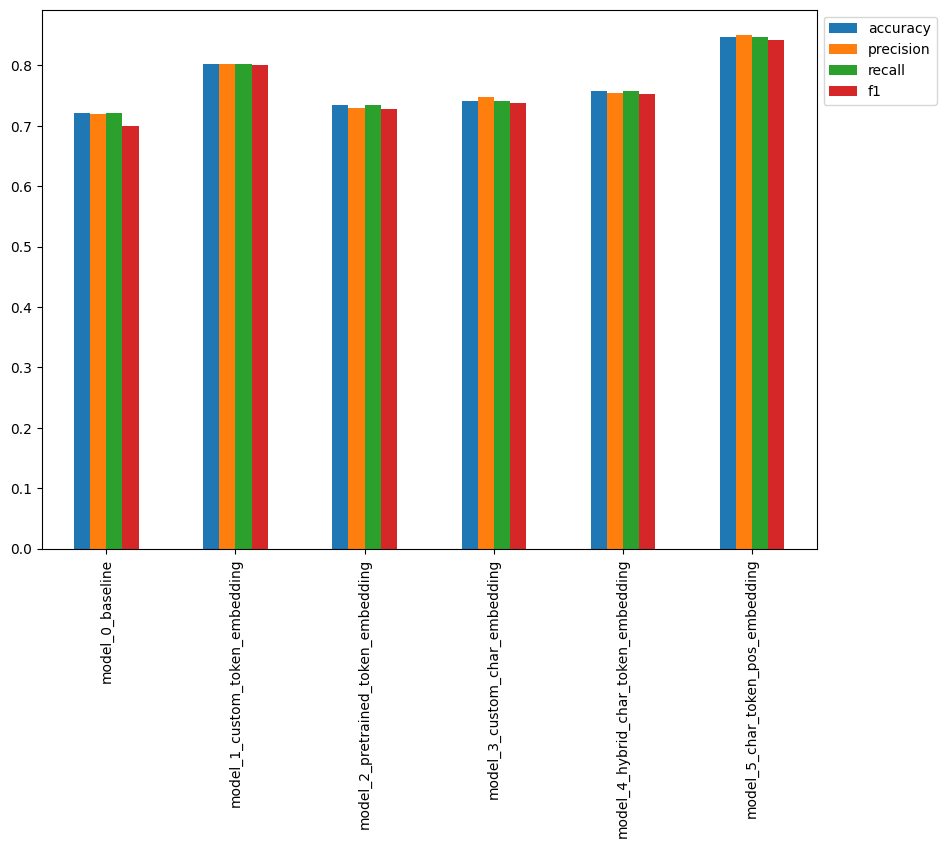

In [138]:
#Plot and compare all model results
all_model_results.plot(kind='bar',figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

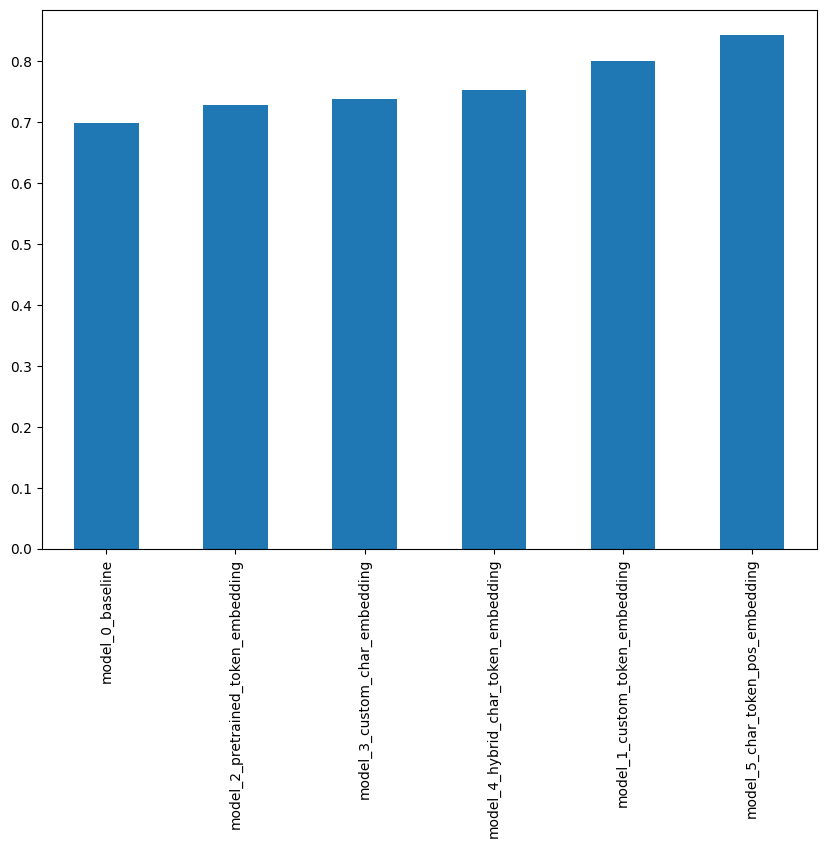

In [140]:
# Sort models results by f1-score
all_model_results.sort_values('f1',ascending=True)['f1'].plot(kind='bar',figsize=(10,7));

## Save and load model

In [143]:
model_5.save('skimlit_tribrid_model.keras')